Loading datasets...
Train: 3063 samples
Test: 1021 samples
Validation: 1021 samples

=== Starting Grid Search for Model Fine-Tuning ===

Tuning SVC...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters for SVC: {'svc__C': 3.0, 'svc__kernel': 'rbf'}
Best validation AUCPR: 95.16%

Tuning Logistic Regression...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for Logistic Regression: {'logisticregression__C': 5.0, 'logisticregression__max_iter': 200, 'logisticregression__solver': 'liblinear'}
Best validation AUCPR: 93.99%

Tuning Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for Random Forest: {'randomforestclassifier__max_depth': 100, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 300}
Best validation AUCPR: 94.21%

=== Evaluating Fine-tuned Models ===

Evaluating SVC...

Results on SVC (Test) dataset:
Accuracy : 97.85%
Precision: 99.06%
Recall   :

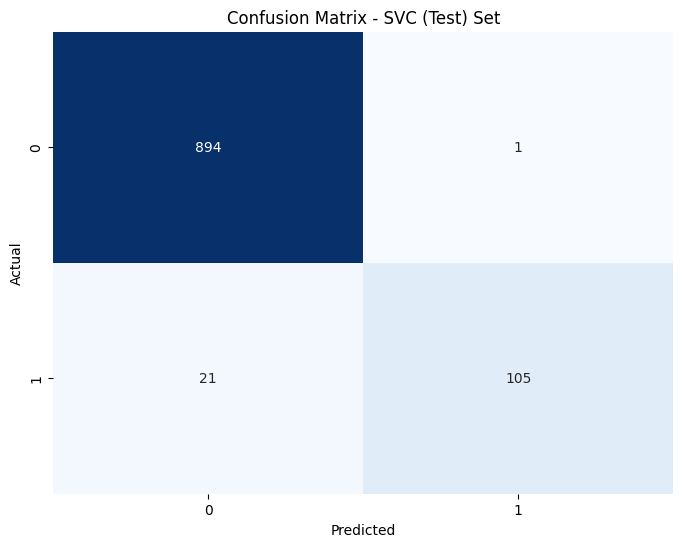


Results on SVC (Validation) dataset:
Accuracy : 97.36%
Precision: 100.00%
Recall   : 78.74%
F1 Score : 88.11%
AUCPR    : 97.11%


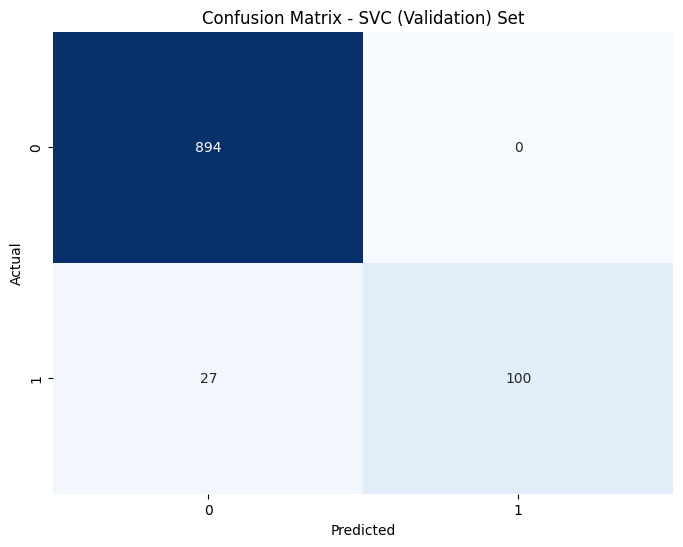


Evaluating Logistic Regression...

Results on Logistic Regression (Test) dataset:
Accuracy : 97.36%
Precision: 97.14%
Recall   : 80.95%
F1 Score : 88.31%
AUCPR    : 96.14%


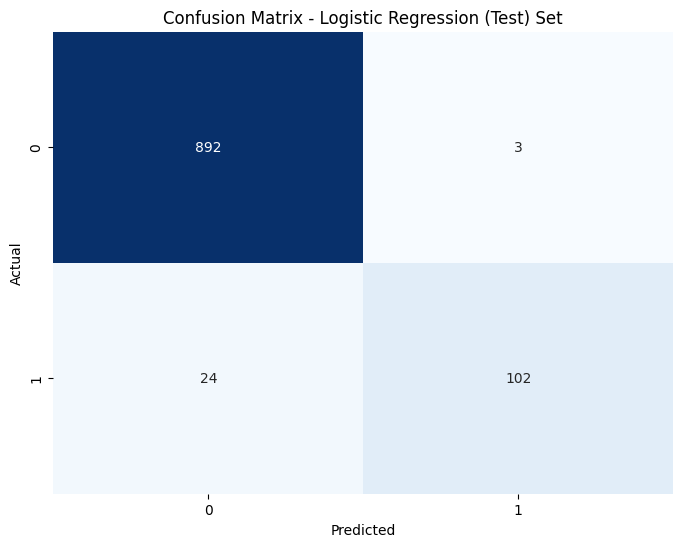


Results on Logistic Regression (Validation) dataset:
Accuracy : 97.16%
Precision: 97.12%
Recall   : 79.53%
F1 Score : 87.45%
AUCPR    : 95.96%


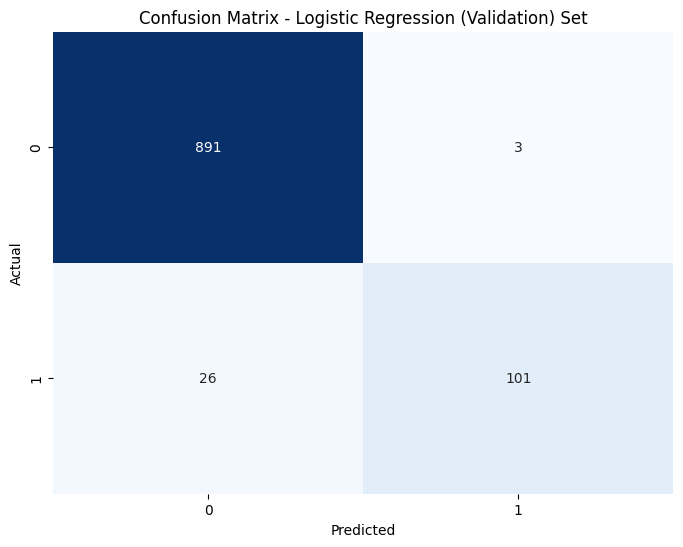


Evaluating Random Forest...

Results on Random Forest (Test) dataset:
Accuracy : 96.57%
Precision: 96.91%
Recall   : 74.60%
F1 Score : 84.30%
AUCPR    : 95.88%


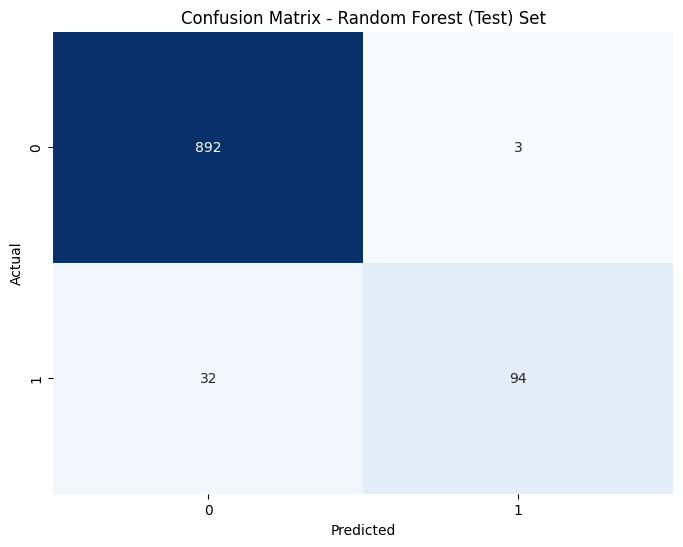


Results on Random Forest (Validation) dataset:
Accuracy : 96.77%
Precision: 97.96%
Recall   : 75.59%
F1 Score : 85.33%
AUCPR    : 95.01%


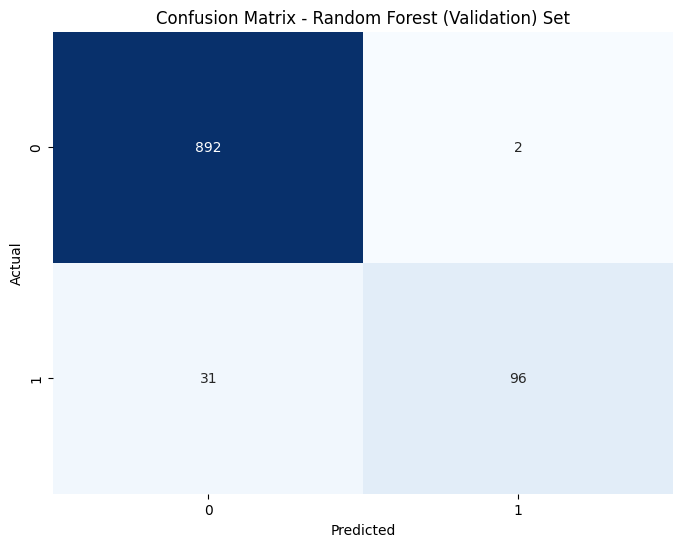


Model Comparison:
                 Model  Test Accuracy  Test Precision  Test Recall    Test F1  \
0                  SVC      97.845250       99.056604    83.333333  90.517241   
1  Logistic Regression      97.355534       97.142857    80.952381  88.311688   
2        Random Forest      96.571988       96.907216    74.603175  84.304933   

   Test AUCPR  Val Accuracy  Val Precision  Val Recall     Val F1  Val AUCPR  
0   97.340269     97.355534     100.000000   78.740157  88.105727  97.111041  
1   96.144318     97.159647      97.115385   79.527559  87.445887  95.957777  
2   95.876546     96.767875      97.959184   75.590551  85.333333  95.009338  

Best model: SVC
Validation AUCPR: 97.11%
Test AUCPR: 97.34%


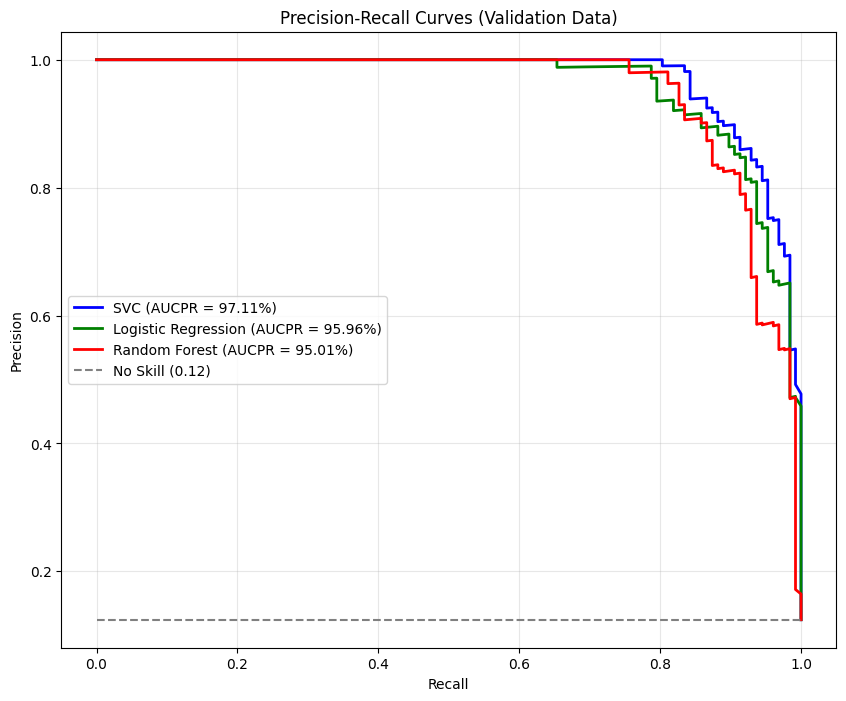

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, confusion_matrix, precision_recall_curve, auc
)

# Set random seed for reproducibility
np.random.seed(21)

# Suppress warnings
warnings.filterwarnings("ignore")

# 1. Load and Prepare Dataset
print("Loading datasets...")
# Update these paths to your actual data locations
# Load datasets
train = pd.read_csv(r"E:\Sem 4\AML ASSIGNEMNT\AppliedMachineLearning\Assignment 2\train.csv").dropna()
test = pd.read_csv(r"E:\Sem 4\AML ASSIGNEMNT\AppliedMachineLearning\Assignment 2\test.csv").dropna()
val = pd.read_csv(r"E:\Sem 4\AML ASSIGNEMNT\AppliedMachineLearning\Assignment 2\validation.csv").dropna()

# Extract features and labels
train_X, train_y = train["Message"], train["Label"]
test_X, test_y = test["Message"], test["Label"]
val_X, val_y = val["Message"], val["Label"]

print(f"Train: {train_X.shape[0]} samples")
print(f"Test: {test_X.shape[0]} samples")
print(f"Validation: {val_X.shape[0]} samples")

# 2. Define Evaluation Function
def evaluate_model(model, X, y, dataset_name="Test", plot=True):
    """Evaluate model and print all metrics"""
    predictions = model.predict(X)
    pred_probs = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y, predictions) * 100
    precision = precision_score(y, predictions) * 100
    recall = recall_score(y, predictions) * 100
    f1 = f1_score(y, predictions) * 100
    aucpr = average_precision_score(y, pred_probs) * 100 if pred_probs is not None else "N/A"
    
    print(f"\nResults on {dataset_name} dataset:")
    print(f"Accuracy : {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall   : {recall:.2f}%")
    print(f"F1 Score : {f1:.2f}%")
    print(f"AUCPR    : {aucpr:.2f}%")
    
    # Plot confusion matrix
    if plot:
        cm = confusion_matrix(y, predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {dataset_name} Set")
        plt.show()
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "aucpr": aucpr,
        "predictions": predictions,
        "probabilities": pred_probs
    }

# 3. Fine-tune Models with Grid Search
# Define the model configurations to test
models_to_tune = {
    "SVC": {
        "base": SVC(probability=True, random_state=21),
        "params": {
            "C": [1.0, 3.0, 5.0],
            "kernel": ["linear", "poly", "rbf"]
        }
    },
    "Logistic Regression": {
        "base": LogisticRegression(random_state=21),
        "params": {
            "C": [1.0, 2.0, 5.0],
            "solver": ["liblinear", "saga"],
            "max_iter": [200, 250, 300]
        }
    },
    "Random Forest": {
        "base": RandomForestClassifier(random_state=21, n_jobs=-1),
        "params": {
            "n_estimators": [200, 300],
            "max_depth": [50, 100],
            "min_samples_split": [10, 15]
        }
    }
}

# Dictionary to store the best model for each algorithm
best_pipelines = {}

# For each model, perform grid search
print("\n=== Starting Grid Search for Model Fine-Tuning ===")

for name, config in models_to_tune.items():
    print(f"\nTuning {name}...")
    
    # Create the pipeline with the TF-IDF vectorizer and the model
    pipeline = make_pipeline(
        TfidfVectorizer(),
        config["base"]
    )
    
    # Prepare the parameter grid for grid search
    # We need to add the model name prefix to the parameters
    model_name = config["base"].__class__.__name__.lower()
    param_grid = {f"{model_name}__{param}": values for param, values in config["params"].items()}
    
    # Create and run grid search
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=3, 
        scoring="average_precision",
        verbose=1
    )
    
    grid_search.fit(train_X, train_y)
    
    # Get the best model
    best_pipelines[name] = grid_search.best_estimator_
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best validation AUCPR: {grid_search.best_score_*100:.2f}%")

# 4. Evaluate Fine-tuned Models
models_metrics = {}

print("\n=== Evaluating Fine-tuned Models ===")

for name, pipeline in best_pipelines.items():
    print(f"\nEvaluating {name}...")
    
    # Evaluate on test set
    test_metrics = evaluate_model(pipeline, test_X, test_y, f"{name} (Test)")
    
    # Evaluate on validation set
    val_metrics = evaluate_model(pipeline, val_X, val_y, f"{name} (Validation)")
    
    # Store results
    models_metrics[name] = {
        "pipeline": pipeline,
        "test_metrics": test_metrics,
        "val_metrics": val_metrics
    }

# 5. Compare Models and Select the Best One
# Create comparison DataFrame
comparison_data = []

for name, data in models_metrics.items():
    comparison_data.append({
        "Model": name,
        "Test Accuracy": data["test_metrics"]["accuracy"],
        "Test Precision": data["test_metrics"]["precision"],
        "Test Recall": data["test_metrics"]["recall"],
        "Test F1": data["test_metrics"]["f1"],
        "Test AUCPR": data["test_metrics"]["aucpr"],
        "Val Accuracy": data["val_metrics"]["accuracy"],
        "Val Precision": data["val_metrics"]["precision"],
        "Val Recall": data["val_metrics"]["recall"],
        "Val F1": data["val_metrics"]["f1"],
        "Val AUCPR": data["val_metrics"]["aucpr"]
    })

comparison = pd.DataFrame(comparison_data)
print("\nModel Comparison:")
print(comparison)

# Find the best model based on validation AUCPR
best_model_name = comparison.loc[comparison["Val AUCPR"].idxmax(), "Model"]
best_model = models_metrics[best_model_name]["pipeline"]
best_val_aucpr = models_metrics[best_model_name]["val_metrics"]["aucpr"]
best_test_aucpr = models_metrics[best_model_name]["test_metrics"]["aucpr"]

print(f"\nBest model: {best_model_name}")
print(f"Validation AUCPR: {best_val_aucpr:.2f}%")
print(f"Test AUCPR: {best_test_aucpr:.2f}%")

# 6. Visualize PR Curves for All Models
# Plot precision-recall curves for all models on validation data
plt.figure(figsize=(10, 8))

colors = ["blue", "green", "red"]
for i, (name, data) in enumerate(models_metrics.items()):
    # Get prediction probabilities and true labels
    y_true = val_y
    y_scores = data["val_metrics"]["probabilities"]
    
    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    
    # Calculate AUCPR
    aucpr = data["val_metrics"]["aucpr"]
    
    # Plot precision-recall curve
    plt.plot(recall, precision, color=colors[i], lw=2,
             label=f"{name} (AUCPR = {aucpr:.2f}%)")

# Add no-skill line (baseline)
no_skill = val_y.mean()
plt.plot([0, 1], [no_skill, no_skill], linestyle="--", color="gray", label=f"No Skill ({no_skill:.2f})")

# Set plot properties
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (Validation Data)")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.show()


In [10]:

# 7. Save the Best Model
model_filename = "best_spam_model.joblib"
joblib.dump(best_model, model_filename)
print(f"\nBest model ({best_model_name}) saved as '{model_filename}'")


Best model (SVC) saved as 'best_spam_model.joblib'


In [13]:
MODEL_PATH = r'E:\Sem 4\AML ASSIGNEMNT\AppliedMachineLearning\Assignment 3\best_spam_model.joblib'
loaded_model = joblib.load(MODEL_PATH)
message = "ur going bahamas callfreefone 08081560665 speak live operator claim either bahamas cruise of£2000 cash 18only opt txt 07786200117"
probability = loaded_model.predict_proba([message])[0][1]
raw_prediction = loaded_model.predict([message])[0]

print(f"Raw prediction output: {raw_prediction}")
print(f"Probability of spam: {probability:.4f}")

Raw prediction output: 1
Probability of spam: 1.0000
